# C√°lculo de la frecuencia cardiaca a partir de datos crudos

Esta vez me baso en el art√≠culo que nos pas√≥ Pablo que describe lo que se espera de hacer con el pulsiox√≠metro

El art√≠culo describe varios m√©todos para calcular la frecuencia card√≠aca a partir de se√±ales PPG (fotopletismograf√≠a). Se detallan tres enfoques principales:

**M√©todo de Cruce por Umbral**:

- Se filtra la se√±al con un **paso alto** para eliminar la **deriva**.

- Se establecen umbrales (positivo y negativo) basados en una fracci√≥n del **valor m√°ximo de la se√±al**.

- Se cuenta **cu√°ntas veces la se√±al cruza los umbrales** para estimar la frecuencia card√≠aca.

**M√©todo de Ventana:**

- Se mantiene una ventana de tama√±o din√°mico (2/3 del per√≠odo estimado del pulso).

- Si un valor se mantiene como un m√°ximo o m√≠nimo en toda la ventana, se considera un pico o valle real.

- Se evita detectar picos falsos debido a la muesca dicr√≥tica.

**M√©todo de Fusi√≥n:**

- Se combinan los dos m√©todos anteriores.

- Si la estimaci√≥n de la ventana difiere m√°s del 25% con el cruce por umbral, se descarta.

- Se usa un filtro de Kalman para suavizar las mediciones y eliminar valores at√≠picos.

## M√©todo de cruce por umbral

Pasos:
    
1. Cargar el archivo CSV y visualizar los datos.

2. Filtrar la se√±al con un filtro pasaaltos para eliminar la deriva.

3. Calcular los umbrales como una fracci√≥n del m√°ximo de la se√±al IR.

4. Contar los cruces de umbral y estimar la frecuencia card√≠aca.

5. Comparar el resultado con la frecuencia de referencia (91 BPM).

### 1. Cargar el archivo

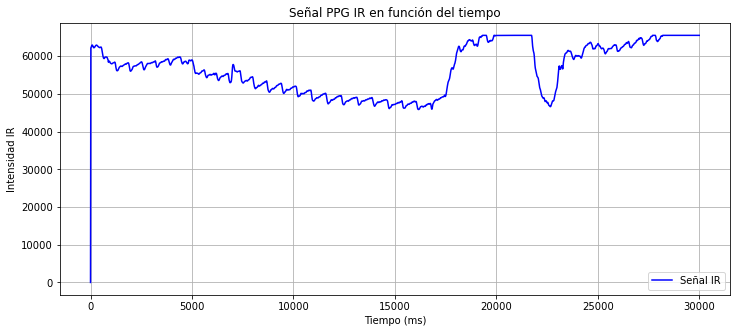

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

_file_path = "C:/Users/Elena/Desktop/GitHub/TFG-Elena-Ruiz/Datos/Datos crudos/save_log2/raw_data_95_77_2.csv"
df = pd.read_csv(file_path, delimiter=";")


# Graficar la se√±al IR original
plt.figure(figsize=(12, 5))
plt.plot(df["Tiempo (ms)"], df["IR"], label="Se√±al IR", color="blue")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad IR")
plt.title("Se√±al PPG IR en funci√≥n del tiempo")
plt.legend()
plt.grid(True)
plt.show()

### 2. Aplicar un filtro pasaaltos para eliminar la deriva

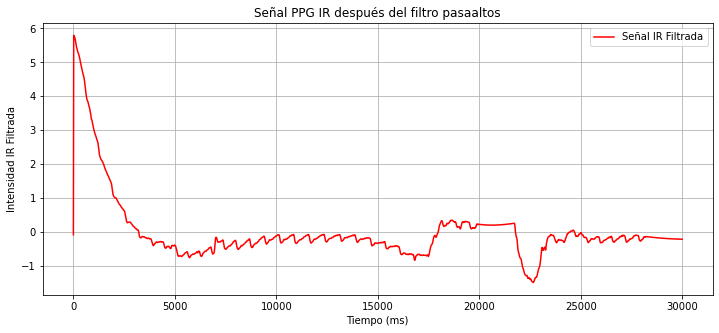

In [2]:
def butter_highpass_filter(data, cutoff=0.5, fs=60, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

fs = 60  # Frecuencia de muestreo estimada (Hz)
filtered_ir = butter_highpass_filter(df["IR"], cutoff=0.1, fs=fs)
filtered_ir = (filtered_ir - np.mean(filtered_ir)) / np.std(filtered_ir)

# Graficar la se√±al filtrada
plt.figure(figsize=(12, 5))
plt.plot(df["Tiempo (ms)"], filtered_ir, label="Se√±al IR Filtrada", color="red")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad IR Filtrada")
plt.title("Se√±al PPG IR despu√©s del filtro pasaaltos")
plt.legend()
plt.grid(True)
plt.show()

### 3. Calcular los umbrales

In [3]:
threshold_high = 0.3 * np.max(filtered_ir) # Umbral alto (50% del m√°x.)
threshold_low = -threshold_high            # Umbral bajo
print(threshold_high)
print(threshold_low)

1.7390492711447638
-1.7390492711447638


### 4. Contar los cruces de umbral

In [4]:
crossings = 0
for i in range(1, len(filtered_ir)):
    if (filtered_ir[i-1] < threshold_high and filtered_ir[i] >= threshold_high) or \
       (filtered_ir[i-1] > threshold_low and filtered_ir[i] <= threshold_low):
        crossings += 1

# Cada latido tiene dos cruces, as√≠ que dividimos entre 2 y calculamos BPM
heart_rate = (crossings / 2) * (fs / len(filtered_ir)) * 60


### 5. Comparar con la referencia


Frecuencia card√≠aca estimada: 1.00 BPM
Frecuencia de referencia: 91 BPM
Error: 90.00 BPM


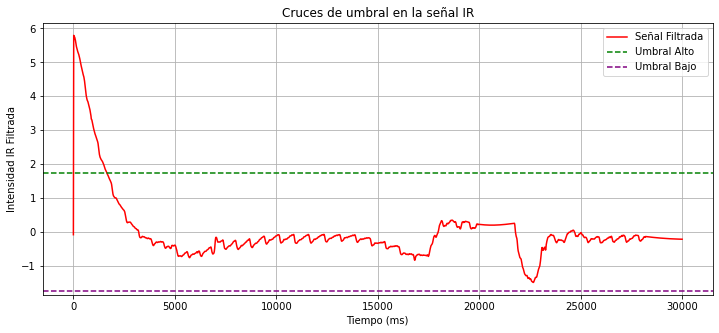

In [5]:
print(f"\nFrecuencia card√≠aca estimada: {heart_rate:.2f} BPM")
print(f"Frecuencia de referencia: 91 BPM")
error = abs(heart_rate - 91)
print(f"Error: {error:.2f} BPM")

# Mostrar los umbrales en la gr√°fica
plt.figure(figsize=(12, 5))
plt.plot(df["Tiempo (ms)"], filtered_ir, label="Se√±al Filtrada", color="red")
plt.axhline(y=threshold_high, color="green", linestyle="--", label="Umbral Alto")
plt.axhline(y=threshold_low, color="purple", linestyle="--", label="Umbral Bajo")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad IR Filtrada")
plt.title("Cruces de umbral en la se√±al IR")
plt.legend()
plt.grid(True)
plt.show()

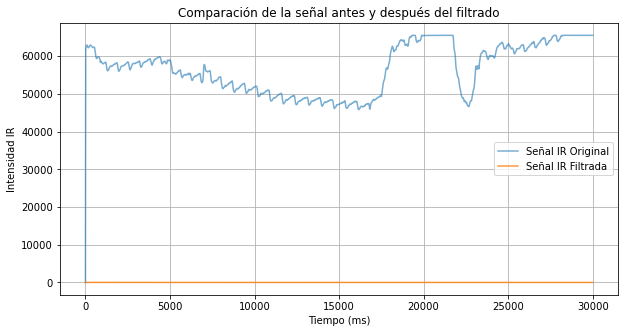

In [6]:
plt.figure(figsize=(10,5))
plt.plot(df["Tiempo (ms)"], df["IR"], label="Se√±al IR Original", alpha=0.6)
plt.plot(df["Tiempo (ms)"], filtered_ir, label="Se√±al IR Filtrada", alpha=0.8)
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad IR")
plt.legend()
plt.title("Comparaci√≥n de la se√±al antes y despu√©s del filtrado")
plt.grid()
plt.show()


## M√©todo de la ventana

Pasos:
- Dividir la se√±al en ventanas de tiempo (por ejemplo, 5 segundos).
- Calcular la frecuencia card√≠aca en cada ventana usando la Transformada de Fourier o detecci√≥n de picos.
- Promediar los valores obtenidos para estimar la frecuencia card√≠aca global.

1. Aplica un filtro pasaaltos para eliminar la deriva.
2. Divide la se√±al en ventanas de 5 segundos.
3. Detecta picos en cada ventana usando find_peaks().
4. Calcula la frecuencia card√≠aca en cada ventana y luego promedia los resultados.
5. Plotea la √∫ltima ventana con los picos detectados.

Frecuencia card√≠aca estimada: 78.00 BPM
Frecuencia de referencia: 77 BPM
Error: 1.00 BPM


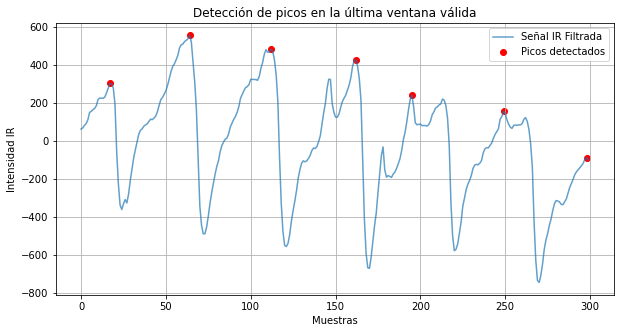

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

# Cargar datos
df = pd.read_csv("C:/Users/Elena/Desktop/GitHub/TFG-Elena-Ruiz/Datos/Datos crudos/save_log2/raw_data_95_77_2.csv", delimiter=";")

# Configuraci√≥n
fs = 60  # Frecuencia de muestreo en Hz
window_size = 5 * fs  # Ventana de 5 segundos

# Filtro pasaaltos
def butter_highpass_filter(data, cutoff=0.5, fs=fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

df["IR_Filtrado"] = butter_highpass_filter(df["IR"], cutoff=0.1, fs=fs)

# Dividir en ventanas y calcular la frecuencia card√≠aca
hr_values = []

for start in range(0, len(df), window_size):
    window = df["IR_Filtrado"].iloc[start:start + window_size]
    
    if len(window) < window_size:
        break  # Ignorar ventanas incompletas

    # Detecci√≥n de picos
    peaks, _ = find_peaks(window, distance=fs*0.5)  # Al menos 0.5s entre picos

    # Calcular frecuencia card√≠aca
    if len(peaks) > 1:
        hr = len(peaks) * (60 / (len(window) / fs))
        hr_values.append(hr)

# Promediar los valores obtenidos
hr_estimated = np.mean(hr_values) if hr_values else 0

# Mostrar resultados
print(f"Frecuencia card√≠aca estimada: {hr_estimated:.2f} BPM")
print(f"Frecuencia de referencia: 77 BPM")
print(f"Error: {abs(hr_estimated - 77):.2f} BPM")

# Visualizar la detecci√≥n de picos en la √∫ltima ventana v√°lida
if hr_values:
    last_window = df["IR_Filtrado"].iloc[-window_size:]
    peaks, _ = find_peaks(last_window, distance=fs*0.5)

    plt.figure(figsize=(10,5))
    plt.plot(last_window.values, label="Se√±al IR Filtrada", alpha=0.7)

    if len(peaks) > 0:
        plt.scatter(peaks, last_window.iloc[peaks], color="red", label="Picos detectados")

    plt.xlabel("Muestras")
    plt.ylabel("Intensidad IR")
    plt.legend()
    plt.title("Detecci√≥n de picos en la √∫ltima ventana v√°lida")
    plt.grid()
    plt.show()

Frecuencia card√≠aca estimada: 80.00 BPM
Frecuencia de referencia: 81 BPM
Error: 1.00 BPM


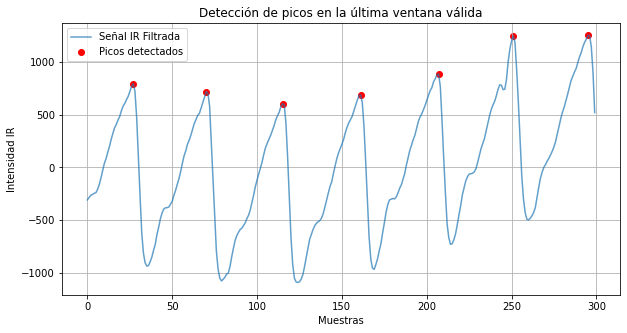

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

# Cargar datos
df = pd.read_csv("C:/Users/Elena/Desktop/GitHub/TFG-Elena-Ruiz/Datos/Datos crudos/save_log2/raw_data_98_81.csv", delimiter=";")

# Configuraci√≥n
fs = 60  # Frecuencia de muestreo en Hz
window_size = 5 * fs  # Ventana de 5 segundos

# Filtro pasaaltos
def butter_highpass_filter(data, cutoff=0.5, fs=fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

df["IR_Filtrado"] = butter_highpass_filter(df["IR"], cutoff=0.1, fs=fs)

# Dividir en ventanas y calcular la frecuencia card√≠aca
hr_values = []

for start in range(0, len(df), window_size):
    window = df["IR_Filtrado"].iloc[start:start + window_size]
    
    if len(window) < window_size:
        break  # Ignorar ventanas incompletas

    # Detecci√≥n de picos
    peaks, _ = find_peaks(window, distance=fs*0.5)  # Al menos 0.5s entre picos

    # Calcular frecuencia card√≠aca
    if len(peaks) > 1:
        hr = len(peaks) * (60 / (len(window) / fs))
        hr_values.append(hr)

# Promediar los valores obtenidos
hr_estimated = np.mean(hr_values) if hr_values else 0

# Mostrar resultados
print(f"Frecuencia card√≠aca estimada: {hr_estimated:.2f} BPM")
print(f"Frecuencia de referencia: 81 BPM")
print(f"Error: {abs(hr_estimated - 81):.2f} BPM")

# Visualizar la detecci√≥n de picos en la √∫ltima ventana v√°lida
if hr_values:
    last_window = df["IR_Filtrado"].iloc[-window_size:]
    peaks, _ = find_peaks(last_window, distance=fs*0.5)

    plt.figure(figsize=(10,5))
    plt.plot(last_window.values, label="Se√±al IR Filtrada", alpha=0.7)

    if len(peaks) > 0:
        plt.scatter(peaks, last_window.iloc[peaks], color="red", label="Picos detectados")

    plt.xlabel("Muestras")
    plt.ylabel("Intensidad IR")
    plt.legend()
    plt.title("Detecci√≥n de picos en la √∫ltima ventana v√°lida")
    plt.grid()
    plt.show()

## M√©todo de fusi√≥n (combinaci√≥n de ambos)

Combina los m√©todos de umbral y ventana para mejorar la precisi√≥n de la detecci√≥n de la frecuencia card√≠aca. Este m√©todo es especialmente √∫til para evitar problemas cuando uno de los m√©todos falla, como cuando el c√°lculo de la ventana se bloquea en una subarm√≥nica.

Pasos:

- Usa el m√©todo de umbral para obtener una estimaci√≥n inicial de la frecuencia card√≠aca.

- Usa el m√©todo de ventana para obtener una segunda estimaci√≥n.

- Fusiona los resultados:

    - Si el m√©todo de ventana es demasiado diferente del de umbral (m√°s del 25%), se descarta la estimaci√≥n de la ventana.

    - Si ambos m√©todos coinciden dentro de un 25%, se considera el valor fusionado.

- Ajustes adicionales:
    - **Kalman filter** para eliminar outliers y suavizar los resultados.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

# Cargar datos
df = pd.read_csv("C:/Users/Elena/Desktop/GitHub/TFG-Elena-Ruiz/Datos/Datos crudos/save_log2/raw_data_95_77_2.csv", delimiter=";")

# üìå Configuraci√≥n
fs = 60  # Frecuencia de muestreo en Hz
window_size = 10 * fs  # Ventana de 10 segundos

# üìå Filtro pasaaltos
def butter_highpass_filter(data, cutoff=0.05, fs=fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

df["IR_Filtrado"] = butter_highpass_filter(df["IR"], cutoff=0.05, fs=fs)

# üìå Funci√≥n para el m√©todo de umbral
def threshold_method(data):
    threshold_high = 0.3 * np.max(data)
    threshold_low = -threshold_high
    crossings = 0
    for i in range(1, len(data)):
        if (data[i-1] < threshold_high and data[i] >= threshold_high) or (data[i-1] > threshold_low and data[i] <= threshold_low):
            crossings += 1
    return (crossings / 2) * (60 / (len(data) / fs))  # Frecuencia card√≠aca estimada

# üìå Funci√≥n para el m√©todo de ventana
def window_method(data):
    peaks, _ = find_peaks(data, height=0.2 * np.max(data), distance=fs*0.5)  # Al menos 0.5s entre picos
    return len(peaks) * (60 / (len(data) / fs))

# üìå Dividir en ventanas y fusionar resultados
hr_values_fusion = []

for start in range(0, len(df) - window_size, window_size):  # Ajuste en el rango
    window = df["IR_Filtrado"].iloc[start:start + window_size]
    
    if len(window) < window_size:
        break  # Ignorar ventanas incompletas

    # M√©todo de umbral
    hr_threshold = threshold_method(window)
    
    # M√©todo de ventana
    hr_window = window_method(window)
    
    # Fusionar resultados
    if abs(hr_threshold - hr_window) <= 0.25 * hr_threshold:
        hr_fused = (hr_threshold + hr_window) / 2
    else:
        hr_fused = hr_window if abs(hr_window - hr_threshold) > 0.25 * hr_threshold else hr_threshold
    
    hr_values_fusion.append(hr_fused)

# üìå Promediar los valores obtenidos
hr_estimated_fusion = np.mean(hr_values_fusion) if hr_values_fusion else 0

# üìå Mostrar resultados
print(f"Frecuencia card√≠aca estimada por fusi√≥n: {hr_estimated_fusion:.2f} BPM")
print(f"Frecuencia de referencia: 91 BPM")
print(f"Error: {abs(hr_estimated_fusion - 91):.2f} BPM")

# üìå Visualizar la detecci√≥n de picos en la √∫ltima ventana v√°lida
if hr_values_fusion:
    last_window = df["IR_Filtrado"].iloc[-window_size:]
    peaks, _ = find_peaks(last_window, height=0.2 * np.max(last_window), distance=fs*0.5)

    plt.figure(figsize=(10,5))
    plt.plot(last_window.values, label="Se√±al IR Filtrada", alpha=0.7)

    if len(peaks) > 0:
        plt.scatter(peaks, last_window.iloc[peaks], color="red", label="Picos detectados")

    plt.xlabel("Muestras")
    plt.ylabel("Intensidad IR")
    plt.legend()
    plt.title("Detecci√≥n de picos en la √∫ltima ventana v√°lida")
    plt.grid()
    plt.show()

KeyError: 0